Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Training model 1
Epoch 1/100
92/92 [==============================] - 9s 91ms/step - loss: 1.0654 - accuracy: 0.5188 - val_loss: 0.7375 - val_accuracy: 0.7152
Epoch 2/100
92/92 [==============================] - 7s 77ms/step - loss: 0.6707 - accuracy: 0.7101 - val_loss: 0.5289 - val_accuracy: 0.7988
Epoch 3/100
92/92 [==============================] - 8s 88ms/step - loss: 0.4916 - accuracy: 0.8039 - val_loss: 0.4396 - val_accuracy: 0.8287
Epoch 4/100
92/92 [==============================] - 6s 63ms/step - loss: 0.3956 - accuracy: 0.8485 - val_loss: 0.3794 - val_accuracy: 0.8647
Epoch 5/100
92/92 [==============================] - 8s 86ms/step - loss: 0.3162 - accuracy: 0.8822 - val_loss: 0.3400 - val_accuracy: 0.8729
Epoch 6/100
92/92 [========================

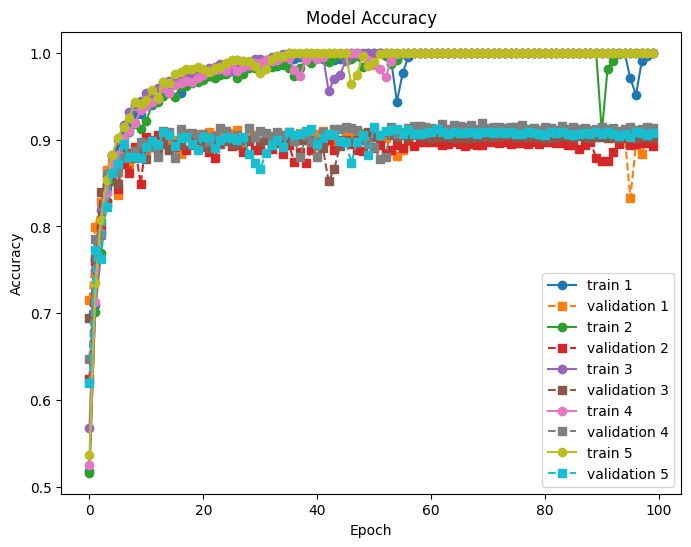

In [5]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
!pip install tensorflow
from tensorflow import keras
# Load UCI HAR dataset
with zipfile.ZipFile("/content/gdrive/MyDrive/UCI HAR Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/tmp/har")

# Load the training and testing data
X_train = np.loadtxt('/tmp/har/UCI HAR Dataset/train/X_train.txt')
y_train = np.loadtxt('/tmp/har/UCI HAR Dataset/train/y_train.txt').astype(int)-1
X_test = np.loadtxt('/tmp/har/UCI HAR Dataset/test/X_test.txt')
y_test = np.loadtxt('/tmp/har/UCI HAR Dataset/test/y_test.txt').astype(int)-1

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape data for Conv1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define model
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
import numpy as np
def random_time_shift(X, max_shift):
    """
    Apply random time shift to the input data.
    """
    if X.ndim == 2:
        X = X[..., np.newaxis]
    n_samples, n_timesteps, n_features = X.shape
    new_X = np.zeros_like(X)
    shifts = np.random.randint(-max_shift, max_shift, size=n_samples)
    for i in range(n_samples):
        new_X[i] = np.roll(X[i], shifts[i], axis=0)
    return new_X


# Create a list of models
models = []
for i in range(5):
    model = create_model(input_shape=(X_train.shape[1], 1), num_classes=6)
    models.append(model)

# Train each model and evaluate its performance
histories = []
for i, model in enumerate(models):
    print(f'Training model {i+1}')
    X_train_shifted = random_time_shift(X_train, max_shift=10)
    X_train_shifted = np.squeeze(X_train_shifted, axis=2)
    X_train_shifted = X_train_shifted.reshape(X_train_shifted.shape[0], X_train_shifted.shape[1], 1)
    history = model.fit(X_train_shifted, y_train, epochs=100, batch_size=64, validation_split=0.2)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test accuracy of model {i+1}: {accuracy:.4f}')
    histories.append(history)



# Define function to create model with specified parameters
def create_model(filters, kernel_size, units):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define parameters for each model in ensemble
models_params = [
    {'filters': 64, 'kernel_size': 3, 'units': 100},
    {'filters': 32, 'kernel_size': 5, 'units': 50},
    {'filters': 128, 'kernel_size': 2, 'units': 150}
]
def generate_adversarial(model, x, y, eps=0.001):
    # Evaluate the original input and label to get the accuracy before adversarial perturbation
    _, original_acc = model.evaluate(x, y)
    
    # Use the Fast Gradient Sign Method (FGSM) to generate adversarial example
    loss_fn = keras.losses.CategoricalCrossentropy()
    x_adv = []
    for i in range(x.shape[0]):
        image = tf.expand_dims(x[i], axis=0)
        label = tf.expand_dims(y[i], axis=0)
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(image)
            loss = loss_fn(label, logits)
        gradients = tape.gradient(loss, image)
        gradients_sign = tf.sign(gradients)
        adv_image = image + eps * gradients_sign
        adv_image = tf.clip_by_value(adv_image, -1, 1)
        x_adv.append(adv_image.numpy()[0])
    x_adv = np.array(x_adv)
    
    # Evaluate the adversarial example and original label to get the accuracy after adversarial perturbation
    _, adv_acc = model.evaluate(x_adv, y)
    
    # Calculate the accuracy difference between the original and adversarial examples
    acc_diff = original_acc - adv_acc
    print("differnece", acc_diff);
    return x_adv

# Create list of models with different parameters
models = [create_model(**params) for params in models_params]
import matplotlib.pyplot as plt
# Train each model on the training data
for i, model in enumerate(models):
    print(f'Training model {i+1}...')
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

for i, model in enumerate(models):
   print(f'Generating adversarial examples for model {i+1}...')
   x_adv = generate_adversarial(model, tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test))


# Make predictions using each model on the test data
y_preds = [model.predict(X_test) for model in models]

# Combine predictions using majority voting
y_pred_combined = np.argmax(np.sum(y_preds, axis=0), axis=1)

# Compute accuracy of combined predictions
accuracy = np.mean(y_pred_combined == np.argmax(y_test, axis=1))
print(f'Accuracy of ensemble model: {accuracy:.2f}')

# Plot the training and validation accuracy for all models
plt.figure(figsize=(8, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], linestyle='-', marker='o', label=f'train {i+1}')
    plt.plot(history.history['val_accuracy'], linestyle='--', marker='s', label=f'validation {i+1}')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
